In [254]:
import simpy
import random 
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [524]:
# To Do #

# check if logic for capacity makes sense, it's supposed to be 10,000 over 5 mins, 10,000 total
# add doc strings to functions
# add colors for outages
# flow diagram (whimsical)
# fix discrepancy between index and minutes (e.g. 1403 vs 1440) (probably just append 10 rows each downtime)

# implement random seed!
# write paragraphs explaining the problem and its significance (mention cost of outages, cost of web farm)
# Justify the validity of the model and discuss how you verified it.
# State your conclusions/ findings from the model. (mention cost of outages, cost of web farm)
# clean up code

# Nice to haves #
# replace weekday vs weekend with mon, tue, wed, thur
# exponetial decay for PR and bot requests

# Completed #
# capture events in dataframe
# plot dataframe
# marketing campaigns, based on week
# counter for bot attack, make it last for 5 minutes
# add randomness to -= request_queue
# create more variables in place of hardcoded values
# calculate summary statistics (total downtime, perc uptime, total outages)

In [513]:
RANDOM_SEED = 212

SIMULATION_MIN = 1440
QUEUE_CAP = 10000
REQS_PER_MIN = 1000
RPM_SD = 300
REQS_RESP_PER_MIN = 2000
RRPM_SD = 400
DOWNTIME_MIN = 10

MK_START = 0
MK_END = 4320
MK_REQS_NUM = 100

BOT_PROB = 0.05
BOT_REQS_NUM = 800
BOT_EFFECT_MIN = 5

PR_PROB = 0.02
PR_REQS_NUM = 1200
PR_EFFECT_MIN = 10

In [514]:
def get_time_of_day(time_of_day_counter):
    # 8:01pm until 6am
    if time_of_day_counter > 1200 or time_of_day_counter < 301:
        time_of_day = ("Night", .9)
    # 6:01am until 12pm
    elif time_of_day_counter > 300 and time_of_day_counter < 721:
        time_of_day = ("Morning", 1)
    # 12:01pm until 8pm
    elif time_of_day_counter > 720 and time_of_day_counter < 1201:
        time_of_day = ("Afternoon", 1.3)
    return time_of_day

def get_day_of_week(day_of_week_counter):
    if day_of_week_counter < 7201:
        day_of_week = ("Weekday", 1)
    elif day_of_week_counter > 7200:
        day_of_week = ("Weekend!", 0.6)
    return day_of_week

def get_marketing_campaign(day_of_week_counter, time_of_day, mk_start, mk_end, mk_reqs_num):
    # Monday - Wednesday
    if day_of_week_counter > mk_start and day_of_week_counter < mk_end and time_of_day == "Afternoon":
        mk_requests = mk_reqs_num
    else:
        mk_requests = 0
    return mk_requests

def get_attack_of_the_bots(bot_prob, bot_reqs_num):
    if np.random.binomial(1, bot_prob):
        bot_requests = bot_reqs_num
    else:
        bot_requests = 0
    return bot_requests

def get_national_press(pr_prob, pr_reqs_num):
    if np.random.binomial(1, pr_prob):
        press_requests = pr_reqs_num
    else:
        press_requests = 0
    return press_requests

def server_sim(sim_min, queue_cap, requests_per_min, rpm_sd, reqs_resp_per_min, rrpm_sd, downtime_min, 
               mk_start, mk_end, mk_reqs_num, bot_prob, bot_reqs_num, bot_effect_min, pr_prob, 
               pr_reqs_num, pr_effect_min):
    downtime_counter = 0
    request_queue = 0
    time_of_day_counter = 1
    day_of_week_counter = 1
    pr_counter = 0
    bot_counter = 0
    i = 1
    
    df_sim = pd.DataFrame(columns = ['Minute', 'Req_Queue', 'Req_Mod', 'Time_of_Day', 
                                     'Day_of_Week', 'Req_MK', 'Req_Bots', 'Req_PR', 
                                     'Req_Orig', 'Downtime', 'Downtime_Min'])
    while i <= sim_min:
        if request_queue < 0:
            request_queue = 0
                
        time_of_day = get_time_of_day(time_of_day_counter)
        day_of_week = get_day_of_week(day_of_week_counter)
        mk_reqs = get_marketing_campaign(day_of_week_counter, time_of_day[0], mk_start, mk_end, mk_reqs_num)
        bot_reqs = get_attack_of_the_bots(bot_prob, bot_reqs_num)
        pr_reqs = get_national_press(pr_prob, pr_reqs_num)

        if pr_reqs > 0:
            pr_counter = pr_effect_min
        
        if pr_counter > 0:
            pr_reqs = pr_reqs_num
            
        if bot_reqs > 0:
            bot_counter = bot_effect_min
        
        if bot_counter > 0:
            bot_reqs = bot_reqs_num
                
        # Generate the starting number of requests for this minute
        avg_req_min = np.random.normal(requests_per_min, rpm_sd, 1)[0]
        
        # Modify number of requests by time of day, day of week, and other factors
        avg_req_min_mod = avg_req_min * time_of_day[1] * day_of_week[1] + mk_reqs + bot_reqs + pr_reqs
  
        # Increment request queue
        request_queue += avg_req_min_mod
        
        # Check for overcapacity and assign overcapacity variable for dataframe
        overcapacity = downtime_min if request_queue > queue_cap else 0
        
        # Append current state to dataframe
        df_sim = df_sim.append({'Minute' : i, 'Req_Queue' : request_queue, 'Req_Mod' : avg_req_min_mod,
                                'Time_of_Day' : time_of_day[0], 'Day_of_Week' : day_of_week[1], 
                                'Req_MK' : mk_reqs, 'Req_Bots' : bot_reqs, 'Req_PR' : pr_reqs, 
                                'Req_Orig' : avg_req_min, 'Downtime' : (request_queue > 10000),
                                'Downtime_Min' : overcapacity}, ignore_index = True)
         
        # 1440 is number of minutes in a day
        if time_of_day_counter == 1440:
            time_of_day_counter = 0
        
        # 10080 is number of minutes in a week
        if day_of_week_counter == 10080:
            day_of_week_counter = 0
        
        # Check for overcapacity and take appropriate actions
        if request_queue > queue_cap:
            print("DOWNTIME!")
            downtime_counter += downtime_min
            i += downtime_min
            time_of_day_counter += downtime_min
            day_of_week_counter += downtime_min
            request_queue = 0
            pr_counter = 0
            bot_counter = 0
            continue
        
        # Removing the number of requests the server was able to respond to
        request_queue -= np.random.normal(reqs_resp_per_min, rrpm_sd, 1)[0]
        
        pr_counter -=1
        bot_counter -=1
        time_of_day_counter +=1
        day_of_week_counter +=1
        i += 1
        
    return df_sim


In [515]:
df_sim = server_sim(SIMULATION_MIN, QUEUE_CAP, REQS_PER_MIN, RPM_SD, REQS_RESP_PER_MIN, RRPM_SD, 
                              DOWNTIME_MIN, MK_START, MK_END, MK_REQS_NUM, BOT_PROB, BOT_REQS_NUM, BOT_EFFECT_MIN,
                              PR_PROB, PR_REQS_NUM, PR_EFFECT_MIN)


DOWNTIME!
DOWNTIME!
DOWNTIME!
DOWNTIME!
DOWNTIME!
DOWNTIME!
DOWNTIME!


In [521]:
print("Downtime minutes: ", sum(df_sim["Downtime_Min"]))
print("Total outages: ", sum(df_sim["Downtime"]))
print("Uptime %: ", 1 - (sum(df_sim["Downtime_Min"]) / df_sim["Minute"][-1:].values[0]))

Downtime minutes:  70
Total outages:  7
Uptime %:  0.9513888888888888


In [522]:
df_sim.tail(30) #[850:900]

,Minute,Req_Queue,Req_Mod,Time_of_Day,Day_of_Week,Req_MK,Req_Bots,Req_PR,Req_Orig,Downtime,Downtime_Min
1347,1411,1053.205138,1053.205138,Night,1,0,0,0,1170.227931,False,0
1348,1412,757.484641,757.484641,Night,1,0,0,0,841.649601,False,0
1349,1413,474.676666,474.676666,Night,1,0,0,0,527.418518,False,0
1350,1414,520.361054,520.361054,Night,1,0,0,0,578.178949,False,0
1351,1415,830.983840,830.983840,Night,1,0,0,0,923.315378,False,0
1352,1416,1159.494746,1159.494746,Night,1,0,0,0,1288.327496,False,0
1353,1417,1059.278943,1059.278943,Night,1,0,0,0,1176.976604,False,0
1354,1418,956.937746,956.937746,Night,1,0,0,0,1063.264162,False,0
1355,1419,1102.902559,1102.902559,Night,1,0,0,0,1225.447288,False,0
1356,1420,910.846414,910.846414,Night,1,0,0,0,1012.051571,False,0


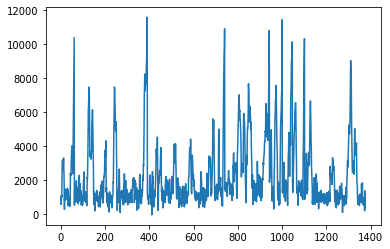

In [518]:
plt.plot(df_sim['Req_Queue'])

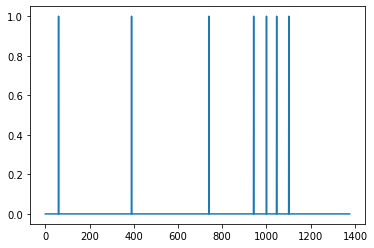

In [519]:
plt.plot(df_sim['Downtime'])

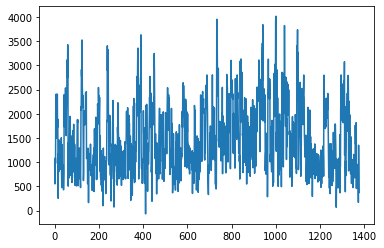

In [520]:
plt.plot(df_sim['Req_Mod'])

In [397]:
# To Do
# counter: downtime
# counter for 5 minutes, ADD 2,000 capacity to queue every minute, but remove any capacity over 10,000 
# counter: hour of day (resets every 1440)
# counter: day of week (resets every 10080)

# check: day of week (return fixed number requests)
# check: time of day (apply multiplier)

# Question how to handle time? timeout vs processes
# Does this work: (1 / avg_req_min)
# How to reset Resource?
# Fulton: look at demand over time (continuous). You can model without a queue. Finite 
# set of demanmd. balance for demand vs supply.
# this is a tank model, overflows 

# Add requests per minute to the queue
# Wait response time (will have randomness)
# When queue (Resource) depletes from 10,000 within 5 mins, increment 10 mins downtime

# add randomness to number request count
# add randomness to response time / number of requests server can handle per minute (i.e. request_queue -= 2000)